# Downloading CSDA data

[NASA's](https://www.nasa.gov/) [Commercial Satellite Data Acquisition (CSDA)](https://www.earthdata.nasa.gov/about/csda) program acquires and provides commercial satellite data for the scientific community.
The program provides a [SpatioTemporal Asset Catalog](https://stacspec.org/) API server for searching and discovering CSDA assets.
We'll [pystac-client](https://github.com/stac-utils/pystac-client) to search the CSDA STAC API for items that we can use.
The CSDA STAC API is public and open, meaning that we don't need any authorization or authentication to use it.

Let's search for [Planet](https://www.planet.com/) items over Longmont, CO, USA in the last year.

In [ ]:
from pystac_client import Client

LONGMONT = {"type": "Point", "coordinates": [-105.1019, 40.1672]}


stac_client = Client.open("https://csdap.earthdata.nasa.gov/stac/")
item_search = stac_client.search(collections=["planet"], intersects=LONGMONT)
item_collection = item_search.item_collection()
print(len(item_collection))

Let's visualize the items, first as a `GeoDataFrame`.

In [ ]:
from geopandas import GeoDataFrame

data_frame = GeoDataFrame.from_features(item_collection.to_dict(), crs="EPSG:4326")
data_frame

Then, on a map (it's pretty noisy).

In [ ]:
import contextily

axes = data_frame.to_crs(epsg=3857).boundary.plot()
contextily.add_basemap(axes)
axes.set_axis_off()

## Download assets

While the STAC API is open, the CSDA Orders API requires authentication.
You'll use your Earthdata username and password to log in.

In [ ]:
import getpass

username = input("Earthdata username: ")
password = getpass.getpass("Earthdata password: ")

Log into CSDA, which creates an access token that encodes your download quotas, among other information.

In [ ]:
from csdap_bulk_download.client import CsdaClient

client = CsdaClient.open(username=username, password=password)
response = client.request("/api/v1/auth/verify", method="GET")
response.raise_for_status()
response.json()

First, let's see how much quota you have for `planet`.
The `/signup` API provides information on how much quota you have been allocated.

In [ ]:
import json

response = client.request(f"/signup/api/users/{username}", method="GET")
response.raise_for_status()
planet = next(
    vendor for vendor in response.json()["vendors"] if vendor["slug"] == "planet"
)
print(json.dumps(planet, indent=2))

The `/api/v1/download/summary` endpoint provide information on data you have downloaded in the past.

In [ ]:
response = client.request(
    f"/api/v1/download/summary?username={username}&provider=planet", method="GET"
)
response.raise_for_status()
print(json.dumps(response.json(), indent=2))

As long as the sum of all of your `area` is less than your `quota`, you're good to download data!
To create a new order, let's first identify the item ids that we want to order.
One of the tricks with Planet data at CSDA is that we've moved "older" data (data that was provided to the program a long time ago) to "cold" storage, meaning that it can't be quickly downloaded.
For this demonstration, we cheat a bit and use an item that we _know_ isn't in cold storage.

In [ ]:
item_search = stac_client.search(
    collections=["planet"],
    ids=["PSScene-20250513_160742_95_253a"],
)
item_collection = item_search.item_collection()
assert len(item_collection) == 1
data_frame = GeoDataFrame.from_features(item_collection.to_dict())
data_frame

The item has several assets.

In [ ]:
import humanize
import tabulate

item = item_collection[0]
rows = []
for key, asset in item.assets.items():
    if file_size := asset.ext.file.size:
        humanized_file_size = humanize.naturalsize(file_size)
    else:
        humanized_file_size = None
    if roles := asset.roles:
        humanized_roles = humanize.natural_list(roles)
    else:
        humanized_roles = roles
    rows.append([key, humanized_roles, asset.media_type, humanized_file_size])
tabulate.tabulate(
    rows, headers=["Key", "Roles", "Type", "File size", "Roles"], tablefmt="html"
)

Key,Roles,Type,File size
thumbnail,thumbnail,,
basic_udm2,data,image/tiff,4.6 MB
ortho_udm2,data,image/tiff,8.2 MB
ortho_visual,data,image/tiff,200.3 MB
json_metadata,metadata,application/json,975 Bytes
basic_analytic_4b,data,image/tiff,352.6 MB
basic_analytic_8b,data,image/tiff,714.4 MB
ortho_analytic_4b,data,image/tiff,586.8 MB
ortho_analytic_8b,data,image/tiff,1.2 GB
ortho_analytic_4b_sr,data,image/tiff,494.2 MB


Let's download the ortho visual asset.

  0%|          | 0/200270461 [00:29<?, ?B/s]
 94%|█████████▍| 180M/191M [00:01<00:00, 117MB/s] 

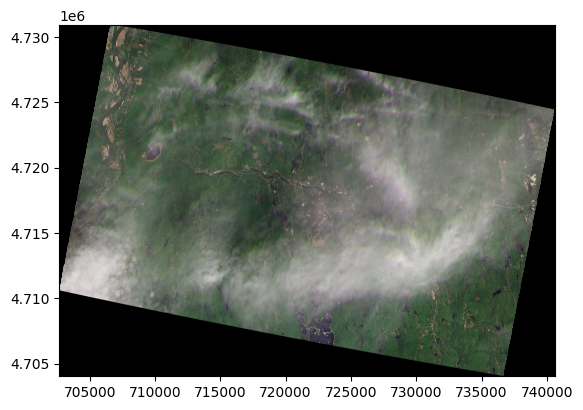

In [57]:
from pathlib import Path
from tempfile import TemporaryDirectory

import rasterio
import rasterio.plot
import tqdm

path = f"/api/v2/download/{item.collection_id}/{item.id}/ortho_visual"
response = client.request(path=path, method="GET", allow_redirects=True, stream=True)
response.raise_for_status()
with TemporaryDirectory() as temporary_directory:
    local_path = Path(temporary_directory) / "ortho_visual.tif"
    progress_bar = progress_bar = tqdm.tqdm(
        total=item.assets["ortho_visual"].ext.file.size,
        unit="B",
        unit_divisor=1024,
        miniters=1,
        unit_scale=True,
    )
    with open(local_path, "wb") as f:
        for chunk in response.iter_content(1024 * 8):
            if chunk:
                f.write(chunk)
                progress_bar.update(len(chunk))
            else:
                progress_bar.close()

    with rasterio.open(local_path) as dataset:
        rasterio.plot.show(dataset)